In [1]:
from DataManagement.data_manager import DataManager
from DataManagement.coin_data import CoinData
from TransferEntropy.transfer_entropy import TransferEntropy
from constants import ATR_ABNORMALITY_COLUMN
# libs
import pandas as pd
import numpy as np

# plotting
import seaborn as sn
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (70,30)


# mutual information
from sklearn.feature_selection import mutual_info_classif

In [2]:
# coin_symbol_list = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "LTCUSDT", "BNBUSDT", "XRPUSDT"]
coin_symbol_list = ["BTCUSDT", "ETHUSDT", "ADAUSDT", "LTCUSDT"]
feature = "close_pct"
kline_size = "1h"
main_coin_symbol = "BTCUSDT"
transfer_entropy_lookback = 10

In [4]:
data_manager = DataManager()
transfer_entropy = TransferEntropy(lookback=transfer_entropy_lookback)

In [8]:
main_1h_df = data_manager.get_historical_data_CoinData(main_coin_symbol, kline_size="1h").df
main_abnromal_timestamps = main_1h_df[main_1h_df[ATR_ABNORMALITY_COLUMN] == 1].index

In [9]:
coin_data_list = [data_manager.get_historical_data_CoinData(coin_symbol, kline_size="1m") for coin_symbol in coin_symbol_list]

# Join close_pct columns of all coins togther

In [10]:
def join_dataframes(coin_data_list, shift):
    df = pd.DataFrame(index=coin_data_list[0].df.index)

    for coin_data in coin_data_list:
        df = df.join(coin_data.df.shift(shift)[feature], how="outer", rsuffix=f"_{coin_data.coin_symbol}", on="timestamp")

    df.rename(columns={"close_pct":f"close_pct_{coin_data_list[0].coin_symbol}"}, inplace=True)    
    df.dropna(inplace=True)
    df.drop(columns=["timestamp"])
    df.set_index("timestamp", inplace=True)
    return df

In [11]:
df = join_dataframes(coin_data_list=coin_data_list, shift=0)

In [12]:
df

,close_pct_BTCUSDT,close_pct_ETHUSDT,close_pct_ADAUSDT,close_pct_LTCUSDT
timestamp,,,,
2018-04-17 04:03:00,0.000410,0.000000,-0.033037,0.000998
2018-04-17 04:04:00,0.000210,0.000374,0.021373,-0.001840
2018-04-17 04:05:00,-0.000368,0.000000,0.000000,-0.000077
2018-04-17 04:06:00,0.000415,-0.000020,0.012338,0.000230
2018-04-17 04:07:00,-0.000383,0.000788,-0.011298,0.000614
...,...,...,...,...
2021-06-30 10:39:00,0.001242,0.000965,0.001122,0.001208
2021-06-30 10:40:00,-0.002035,-0.002306,-0.001419,-0.003194
2021-06-30 10:41:00,-0.000905,-0.000366,-0.000599,-0.000641


# Create correl df

In [13]:
def mutual_information(a, b):
    return mutual_info_regression(a.reshape(-1,1), b, discrete_features = False)[0]

In [14]:
def get_correl_matrix_list(df, method = 'spearman'):
    resampled_list = list(df.resample(rule="1h"))
    alltime_correlation_matrix_list, abnormal_correlation_matrix_list = [],[]

    skipping_counter = 0
    for timestamp, temp_df in resampled_list: # every df is the 1min data from that hour.
            
        if temp_df.empty:
            skipping_counter += 1
            continue
        try:
            temp_correl_matrix = temp_df.corr(method=method).to_numpy() # df of correlation between columns. 4x4
        except:
            skipping_counter += 1
            continue
        
        if np.any(np.isnan(temp_correl_matrix)):
            skipping_counter += 1
            continue
        
        if timestamp in main_abnromal_timestamps:
            abnormal_correlation_matrix_list.append(temp_correl_matrix)
        
        alltime_correlation_matrix_list.append(temp_correl_matrix)

    
    # transfrom to np.array
    abnormal_correlation_matrix_list = np.array(abnormal_correlation_matrix_list)
    alltime_correlation_matrix_list = np.array(alltime_correlation_matrix_list)
    
    # print skipping precent
    print(f"skipping precent {(skipping_counter/len(resampled_list))*100} %")
    return alltime_correlation_matrix_list, abnormal_correlation_matrix_list

# mutual info

In [15]:
# alltime_mi_matrix_list, abnormal_mi_matrix_list = get_correl_matrix_list(df, method=mutual_information)

# correl

In [16]:
alltime_correlation_matrix_list, abnormal_correlation_matrix_list = get_correl_matrix_list(df)

skipping precent 0.2990707444725318 %


In [17]:
def plot_heatmap(correl_df, title, shift = 0):
    mean_corr_df = pd.DataFrame(index=coin_symbol_list, columns=coin_symbol_list, data=correl_df)

    fig_size = max(len(df.columns), 10)
    sn.set(rc={"figure.figsize":tuple([fig_size]*2)})
    title = f"Settings - feature:{feature} | time-frame:{kline_size} | main-coin:{main_coin_symbol} | shift:{shift}\n" + title

    sn.heatmap(mean_corr_df, annot=True).set(title=title);

def plot_heatmap_on_axes(data, title, axes):
    fig_size = 10
    sn.set(rc={"figure.figsize":tuple([fig_size]*2)})

    mean_corr_df = pd.DataFrame(index=coin_symbol_list, columns=coin_symbol_list, data=data)
    sn.heatmap(mean_corr_df, annot=True, ax=axes).set(title=title);

In [18]:
def plot_heatmap_master(coin_data_list, correl_method = 'spearman', shift = 0):
    df = join_dataframes(coin_data_list=coin_data_list, shift=shift)
    alltime_correl_matrix_list, abnormal_correl_matrix_list = get_correl_matrix_list(df, method=correl_method)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(70,20))
    fig.suptitle(f"Settings - feature:{feature} | time-frame:{kline_size} | main-coin:{main_coin_symbol} | shift:{shift}\n")
    
    alltime_correl_mean = alltime_correl_matrix_list.mean(axis=0)
    abnormal_correl_mean = abnormal_correl_matrix_list.mean(axis=0)

    title_data_dict = {
        "alltime Mean of 1min correlation": alltime_correl_mean, 
        "abnormal Mean of 1min correlation":abnormal_correl_mean, 
        "abnromal - alltime": abnormal_correl_mean-alltime_correl_mean}
    for i, (title, data) in enumerate(title_data_dict.items()):
        plot_heatmap_on_axes(data=data, title=title, axes=axes[i])
    fig.tight_layout()
    fig.savefig("yeet.png")

skipping precent 0.2990707444725318 %


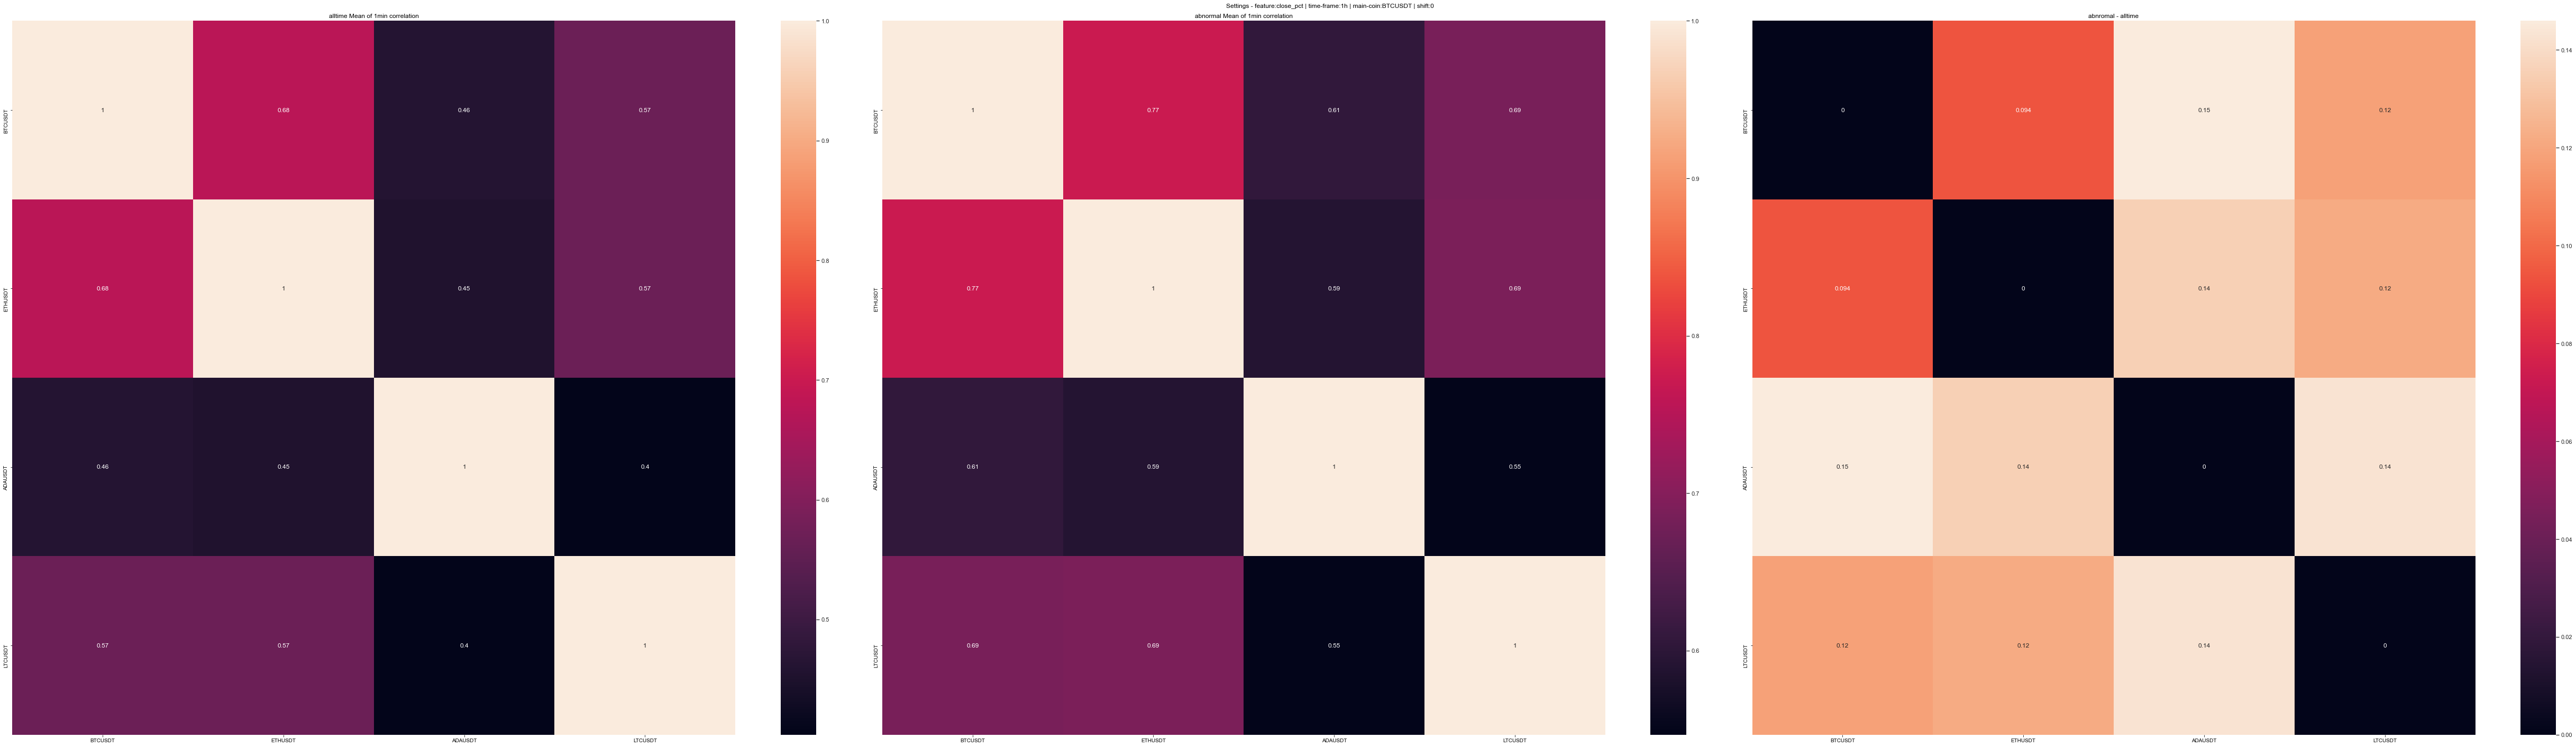

In [19]:
plot_heatmap_master(coin_data_list)

# Pearson Correlation

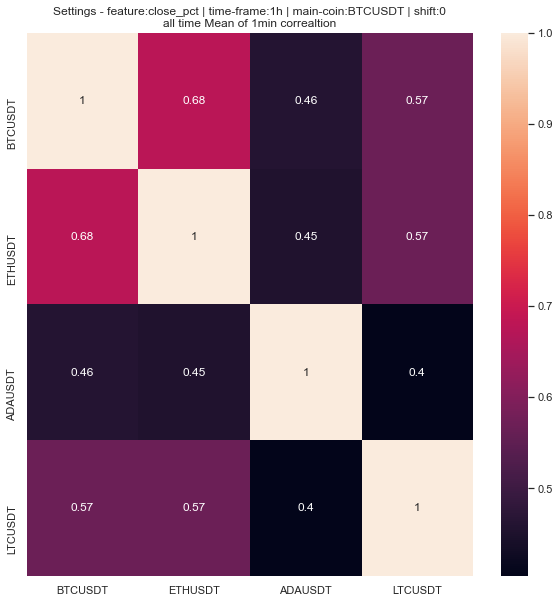

In [20]:
plot_heatmap(alltime_correlation_matrix_list.mean(axis=0), "all time Mean of 1min correaltion")

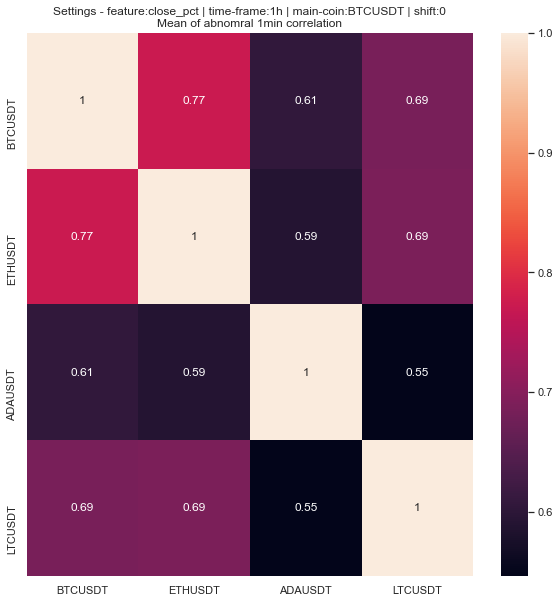

In [21]:
plot_heatmap(abnormal_correlation_matrix_list.mean(axis=0), "Mean of abnomral 1min correlation")

# Difference

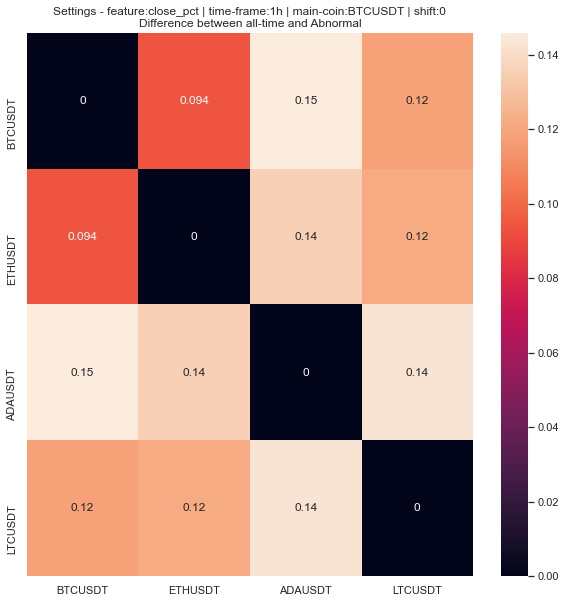

In [22]:
plot_heatmap(abnormal_correlation_matrix_list.mean(axis=0)-alltime_correlation_matrix_list.mean(axis=0), "Difference between all-time and Abnormal")

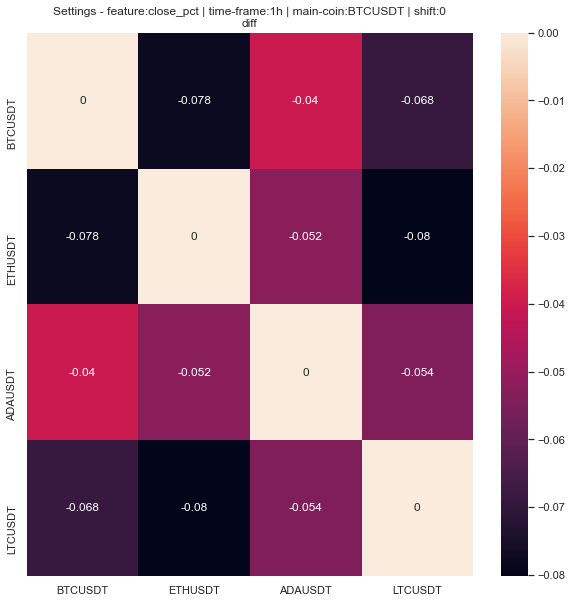

In [23]:
plot_heatmap(abnormal_correlation_matrix_list.std(axis=0)-alltime_correlation_matrix_list.std(axis=0), "diff")

# MI

In [24]:
plot_heatmap(abnormal_mi_matrix_list.mean(axis=0), "all time")

NameError: name 'abnormal_mi_matrix_list' is not defined

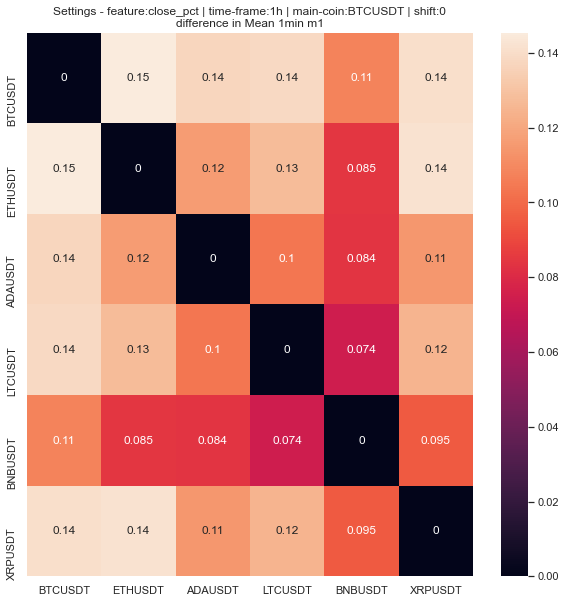

In [ ]:
plot_heatmap(abnormal_mi_matrix_list.mean(axis=0) - alltime_mi_matrix_list.mean(axis=0), "difference in Mean 1min m1")